In [1]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.googlenet import googlenet
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

## Prepare Data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/home/akhil/lyft_predict/l5kit-1.5.0"
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./agent_motion_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'googlenet2', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'train_data_loader': {'key': 'scenes/train/train.zarr', 'batch_size': 4, 'shuffle': True, 'num_workers': 0}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 8, 'shuffle': False, 'num_workers': 4}, 'train_params': {'checkpoint_every_n_steps': 1000, 'max_num_steps': 50000, 'eval_every_n_steps': 500}}


## Model 
The model I have used is a `GoogLeNet` (Not pretrained) with the input and output layers are adjusted according to the Rasterizer output and the prediction steps respectively. i.e. Check agent_motion_config.yaml file for the input layer size (Rasterizer Output) and output from the final layer of the model is the `prediction horizon * (X, Y) coordinates`. If the prediction horizon is 20, then `20 * 2 = 40` is the output `num_targets`   

In [3]:
def custom_model(cfg: Dict) -> torch.nn.Module:

    # Lets try a Pretrained Model version first 
#     model = googlenet(weights=True)

    model = googlenet()
    # change input channels number to match the rasterizer's output
    num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
    num_in_channels = 3 + num_history_channels
    model.conv1 = nn.Conv2d(
        num_in_channels,
        model.conv1.conv.out_channels,
        kernel_size=model.conv1.conv.kernel_size,
        stride=model.conv1.conv.stride,
        padding=model.conv1.conv.padding,
        bias=False,
    )
    # change output size to (X, Y) * number of future states
    num_targets = 2 * cfg["model_params"]["future_num_frames"]
    model.fc = nn.Sequential(nn.Linear(in_features=1024, out_features=512),
                             nn.Linear(in_features=512, out_features=num_targets))
    print(num_targets)
    return model

In [11]:
def forward(data, model, device, criterion):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)
    
    # Forward pass
    
        # When training the model use
#     outputs = model(inputs).logits.reshape(targets.shape)
    
        # When evaluating the model use 
    outputs = model(inputs).reshape(targets.shape)
        
    loss = criterion(outputs, targets)
    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = loss * target_availabilities
    loss = loss.mean()
    return loss, outputs

## Load the Train Data

Our data pipeline map a raw `.zarr` folder into a multi-processing instance ready for training by:
- loading the `zarr` into a `ChunkedDataset` object. This object has a reference to the different arrays into the zarr (e.g. agents and traffic lights);
- wrapping the `ChunkedDataset` into an `AgentDataset`, which inherits from torch `Dataset` class;
- passing the `AgentDataset` into a torch `DataLoader`

In [5]:
# ===== INIT DATASET
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [6]:
!cat /proc/sys/vm/overcommit_memory
# sudo echo 1 > /proc/sys/vm/overcommit_memory

1


In [6]:
# ==== INIT MODEL
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = custom_model(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction="none")
model

cuda:0
100


/home/akhil/anaconda3/envs/lyft/lib/python3.9/site-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


GoogLeNet(
  (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch2): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(192, 96, kernel_si

# Training

note: if you're on MacOS and using `py_satellite` rasterizer, you may need to disable opencv multiprocessing by adding:
`cv2.setNumThreads(0)` before the following cell. This seems to only affect running in python notebook and it's caused by the `cv2.warpaffine` function

In [7]:
# ==== TRAIN LOOP
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
losses_train = []

for _ in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    model.train()
    torch.set_grad_enabled(True)
    loss, _ = forward(data, model, device, criterion)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")

# Auto saves model and its trained weights to drive after training is complete
torch.save(model.state_dict(), "../../trained_models/predict_GLNET2__PreT_50K")

loss: 4.759471416473389 loss(avg): 25.364292374505716: 100%|█| 50000/50000 [1:08


### Manually save Trained Model to Drive

Specify proper path to save to your local drive

In [ ]:
torch.save(model.state_dict(), "../../trained_models/predict_GLNET__PreT_50K")

### Load Trained model from drive  
Load the trained model (These options are to load a specific model you want to evaluate and is optional)

In [8]:
# model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load("../../trained_models/predict_model1_params"))
model.eval()

ResNet(
  (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Plot Loss Curve
We can plot the train loss against the iterations (batch-wise)

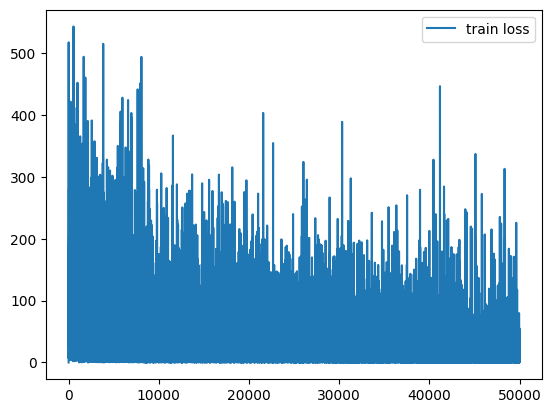

In [8]:
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
plt.legend()
plt.show()

# Evaluation

Evaluation follows a slightly different protocol than training. When working with time series, we must be absolutely sure to avoid leaking the future in the data.

If we followed the same protocol of training, one could just read ahead in the `.zarr` and forge a perfect solution at run-time, even for a private test set.

As such, **the private test set for the competition has been "chopped" using the `chop_dataset` function**.

In [9]:
# ===== GENERATE AND LOAD CHOPPED DATASET
num_frames_to_chop = 100
eval_cfg = cfg["val_data_loader"]
eval_base_path = create_chopped_dataset(dm.require(eval_cfg["key"]), cfg["raster_params"]["filter_agents_threshold"], 
                              num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)

copying: 100%|████████████████████████████████| 100/100 [00:02<00:00, 36.96it/s]
/home/akhil/anaconda3/envs/lyft/lib/python3.9/site-packages/l5kit/evaluation/extract_ground_truth.py:52: RuntimeWarning: you're running with a custom agents_mask
  dataset = AgentDataset(cfg=cfg, zarr_dataset=zarr_dataset, rasterizer=rasterizer, agents_mask=agents_mask)
extracting GT: 100%|█████████████████████████| 480/480 [00:01<00:00, 265.03it/s]


In [17]:
num_frames_to_chop = 100
eval_cfg = cfg["val_data_loader"]
eval_base_path = "/home/akhil/lyft_predict/l5kit-1.5.0/scenes/sample_chopped_100"

The result is that **each scene has been reduced to only 100 frames**, and **only valid agents in the 100th frame will be used to compute the metrics**. Because following frames in the scene have been chopped off, we can't just look ahead to get the future of those agents.

In this example, we simulate this pipeline by running `chop_dataset` on the validation set. The function stores:
- a new chopped `.zarr` dataset, in which each scene has only the first 100 frames;
- a numpy mask array where only valid agents in the 100th frame are True;
- a ground-truth file with the future coordinates of those agents;

Please note how the total number of frames is now equal to the number of scenes multipled by `num_frames_to_chop`. 

The remaining frames in the scene have been sucessfully chopped off from the data

In [10]:
eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(eval_cfg["key"])).name)
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
eval_gt_path = str(Path(eval_base_path) / "gt.csv")

eval_zarr = ChunkedDataset(eval_zarr_path).open()
eval_mask = np.load(eval_mask_path)["arr_0"]
# ===== INIT DATASET AND LOAD MASK
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   10000    |   751440   |     130740    |       0.28      |        100.00        |        75.14         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


/tmp/ipykernel_3977/759707663.py:8: RuntimeWarning: you're running with a custom agents_mask
  eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)


### Storing Predictions
There is a small catch to be aware of when saving the model predictions. The output of the models are coordinates in `agent` space and we need to convert them into displacements in `world` space.

To do so, we first convert them back into the `world` space and we then subtract the centroid coordinates.

In [12]:
# ==== EVAL LOOP
model.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []
agent_ids = []

progress_bar = tqdm(eval_dataloader)
for data in progress_bar:
    _, ouputs = forward(data, model, device, criterion)
    
    # convert agent coordinates into world offsets
    agents_coords = ouputs.cpu().numpy()
    world_from_agents = data["world_from_agent"].numpy()
    centroids = data["centroid"].numpy()
    coords_offset = transform_points(agents_coords, world_from_agents) - centroids[:, None, :2]
    
    future_coords_offsets_pd.append(np.stack(coords_offset))
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy())
    

100%|███████████████████████████████████████████| 60/60 [00:02<00:00, 27.74it/s]


### Save results
After the model has predicted trajectories for our evaluation set, we can save them in a `csv` file.

During the competition, only the `.zarr` and the mask will be provided for the private test set evaluation.
Your solution is expected to generate a csv file which will be compared to the ground truth one on a separate server

In [13]:
pred_path = f"{gettempdir()}/pred.csv"

write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
              )

### Perform Evaluation
Pleae note that our metric supports multi-modal predictions (i.e. multiple predictions for a single GT trajectory). In that case, you will need to provide a confidence for each prediction (confidences must all be between 0 and 1 and sum to 1).

In this simple example we don't generate multiple trajectories, so we won't pass any confidences vector. Internally, the metric computation will assume a single trajectory with confidence equal to 1

In [18]:
metrics = compute_metrics_csv(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)


neg_multi_log_likelihood 640.5920972065695
time_displace [0.17723285 0.3033681  0.40748337 0.55046227 0.66067845 0.80040262
 0.92393559 1.02915813 1.16101162 1.28347076 1.38810344 1.49854138
 1.57459188 1.6910673  1.79411187 1.92849909 2.00192972 2.08168066
 2.16783404 2.23969147 2.34081618 2.43287899 2.52393897 2.62367839
 2.73477982 2.82683067 2.95900244 3.05271044 3.13853751 3.19025796
 3.32408829 3.44121448 3.53552916 3.63528461 3.74665788 3.85111363
 3.94576638 4.01560737 4.13044806 4.2256006  4.34160829 4.41311476
 4.51891114 4.58410467 4.68812223 4.60830578 4.66624234 4.78442051
 4.81689486 4.95482078]


### Visualise Results
We can also visualise some results from the ego (AV) point of view for those frames of interest (the 100th of each scene).

However, as we chopped off the future from the dataset **we must use the GT csv if we want to plot the future trajectories of the agents**


Done


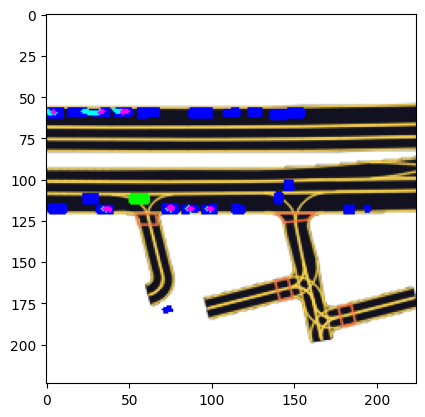

In [15]:
model.eval()
torch.set_grad_enabled(False)
model_name = str(cfg["model_params"]["model_architecture"])
trained_epochs = int(cfg["train_params"]["max_num_steps"]/1000)

path = "./output/"+model_name
try: 
    os.mkdir(path) 
except OSError as error: 
    print(error)

# build a dict to retrieve future trajectories from GT
gt_rows = {}
for row in read_gt_csv(eval_gt_path):
    gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

eval_ego_dataset = EgoDataset(cfg, eval_dataset.dataset, rasterizer)
i = 0
for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
    agent_indices = eval_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
    predicted_positions = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = eval_dataset[v_index]

        out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
        out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
        # store absolute world coordinates
        predicted_positions.append(transform_points(out_pos, data_agent["world_from_agent"]))
        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])

    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)
      
# Saves outputs to drive (Specify proper PATH)
    plt.imshow(im_ego)
    plt.savefig("./output/"+model_name+"/GoogleNet_"+str(trained_epochs)+"k_full{y}.png".format(y=i))
    i += 1

# To visualize here uncomment the below line 
#     plt.show()

print("Done")

### Save Output as Video

This will save the output generated by the current model as a `15 FPS RAW`video with file name as `model_name_epochs.avi` in the current directory

In [17]:
import cv2
import os


model_name = cfg["model_params"]["model_architecture"]
trained_epochs = int(cfg["train_params"]["max_num_steps"]/1000)

# image_folder = 'Path to images saved in drive'
image_folder = './output/'+str(model_name)

output_vid_name = str(model_name)+"_"+ str(trained_epochs)+"K"
video_name = output_vid_name +'.avi'
video_name
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 5, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

# cv2.destroyAllWindows()
video.release()
print("Done")

Done
